# Datagen

In [38]:
!pip install aesthetix

In [39]:
import tensorflow as tf
import time
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

print(tf.__version__)

2.2.0


In [40]:
import os
import numpy as np 
from sklearn.model_selection import train_test_split
import aesthetix as at

# Downloading movie_lines
if "movie_lines.txt" not in os.popen("ls").read():
  !wget https://raw.githubusercontent.com/Stellarator-X/ConvoBot/servus/Programming%20Assignments/Response%20Generation/movie_lines.txt

movielines = open("movie_lines.txt", mode='r')
print(movielines)
lines = movielines.readlines()
print(len(lines))

def clean_str(_str):
  _str = _str.strip()
  _str = _str.lower()
  _str = _str.replace(".", "")
  _str = _str.replace(",", "")
  _str = _str.replace("?", "")
  _str = _str.replace("!", "")
  _str = _str.replace(":", "")
  _str = _str.replace(">", "")
  _str = _str.replace("<", "")
  _str = _str.replace("-", " ")
  _str = _str.replace("_", " ")
  _str = _str.replace("\\", "")
  _str = _str.replace("  ", " ")
  return _str



<_io.TextIOWrapper name='movie_lines.txt' mode='r' encoding='UTF-8'>
304713


In [41]:
sample_size = 20000
cleanlines = []
for i, line in enumerate(lines[:sample_size]):
  at.progress_bar("Cleaning the lines", i, len(lines[:sample_size]))
  speaker, line = line.split('+++$+++ ')[-2:]
  cleanlines.append([speaker.split(" ")[0], line.split('\n')[0]])

cleanlines.reverse()
cleanlines = np.array(cleanlines)
for line in cleanlines[:10]:
  print(line[0],":",line[1])


# Forming the dataset 
response_data = []
l = len(cleanlines)-1
for i, line in enumerate(cleanlines[:-1]):
  at.progress_bar("Generating Stimulus-Response Pairs", i, l)
  speaker, utterance = line
  next_speaker, next_utterance = cleanlines[i+1]
  if speaker is not next_speaker:
    response_data.append(np.array(["<start> "+clean_str(utterance)+" <end>", "<start> "+clean_str(next_utterance)+" <end>"]))
  
response_data = np.array(response_data)
print(response_data.shape)
print(response_data[-10:])

Cleaning the lines:[==============================](100.00%)  
PRINCESS : Sir, I... come to beg you to confess all, and swear allegiance to the king, that he might show you mercy.
WALLACE : Will he show mercy to my country? Will he take back his soldiers, and let us rule ourselves?
PRINCESS : Mercy... is to die quickly. Perhaps even live in the Tower. In time, who knows what can happen, if you can only live.
WALLACE : If I swear to him, then everything I am is dead already.
PRINCESS : You will die! It will be awful!
WALLACE : Every man dies. Not every man really lives.
PRINCESS : Drink this! It will dull your pain.
WALLACE : It will numb my wits, and I must have them all. If I'm senseless, or if I wail, then Longshanks will have broken me.
PRINCESS : I can't bear the thought of your torture. Take it!
NICOLETTE : When the king returns he will bury them in those new clothes. Scotland is in chaos. Your husband is secretly sending an army north.
Generating Stimulus-Response Pairs:[========

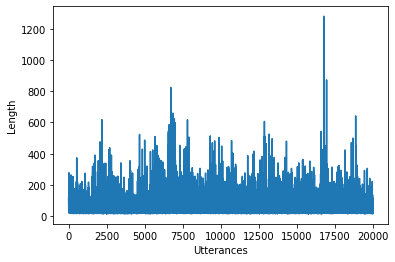

64.50467523376169
Longest utterance :  <start> you've got penthouse playboy hustler etc nobody even considers them pornography anymore then there's mainstream hardcore triple x the difference is penetration that's hardcore that whole industry's up in the valley writers directors porn stars they're celebrities or they think they are they pump out 150 videos a week a week they've even got a porno academy awards america loves pornography anybody tells you they never use pornography they're lying somebody's buying those videos somebody's out there spending 900 million dollars a year on phone sex know what else it's only gonna get worse more and more you'll see perverse hardcore coming into the mainstream because that's evolution desensitization oh my god elvis presley's wiggling his hips how offensive nowadays mtv's showing girls dancing around in thong bikinis with their asses hanging out know what i mean for the porn addict big tits aren't big enough after a while they have to be the big

In [42]:
a = [len(s) for s in response_data[:,0]]
plt.plot(a)
plt.xlabel("Utterances")
plt.ylabel("Length")
plt.show()
print(np.mean(np.array(a)))
print("Longest utterance : ", response_data[np.argmax(a), 0])

In [43]:
# Preprocessing the Data
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences

oov_token = "<OOV>"
max_length = 25
stimuli = response_data[:, 0]
responses = response_data[:, 1]

tokenizer = Tokenizer(oov_token=oov_token, filters = "")
tokenizer.fit_on_texts(stimuli)
# with open("Tokens.txt") as file:
#   json_string = file.read()
# tokenizer = tokenizer_from_json(json_string)

word_index = tokenizer.word_index
index_word = {word_index[word]:word for word in word_index}
vocab_size = len(word_index)
stimulus_sequences = tokenizer.texts_to_sequences(stimuli)
response_sequences = tokenizer.texts_to_sequences(responses)

padded_stimulus_sequences = pad_sequences(stimulus_sequences, maxlen = max_length ,padding = 'post', truncating = 'post')
padded_response_sequences = pad_sequences(response_sequences, maxlen = max_length, padding = 'post', truncating = 'post')


In [44]:
json_string = tokenizer.to_json()
with open("Tokens.txt", "w") as file:
  file.write(json_string)

In [45]:
vocab_size

13356

In [46]:
# json_string

In [47]:
def encode_texts(str_list, tokenizer=tokenizer, max_length = max_length):
  # print(str_list)
  str_list = ["<start> " + s + " <end>" for s in str_list]
  seq = tokenizer.texts_to_sequences(str_list)
  pad_seq = pad_sequences(seq, max_length, padding  ='post', truncating='post')
  return pad_seq

def decode_seq(seq_list, tokenizer = tokenizer):
  ret = tokenizer.sequences_to_texts(seq_list)
  ret = [s.split("<start>")[1].split("<end>")[0][1:-1] for s in ret]
  return np.array(ret)

print(encode_texts(['hello there', 'bye']))

print(decode_seq(encode_texts(['hello there', 'bye'])))

[[   2  341   61    3    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   2 1017    3    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
['hello there' 'bye']


In [48]:
X_train,  X_test, y_train,  y_test = train_test_split(padded_stimulus_sequences[10000:30000], padded_response_sequences[10000:30000], test_size = 0.1)

In [49]:
print(X_train.shape)
print(y_train.shape)

(8999, 25)
(8999, 25)


In [50]:
# Creating a tf dataset
BUFFER_SIZE = len(X_train)
BATCH_SIZE = 100
steps_per_epoch = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 100
units = 1000

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder = True)


In [51]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE, drop_remainder=True)

In [52]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([100, 25]), TensorShape([100, 25]))

In [53]:
# Getting the trained GloVe embeddings

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-06-25 11:03:55--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 2404:6800:4008:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  96.8MB/s    in 3.6s    

2020-06-25 11:03:59 (92.9 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



# LDA Inclusion

In [54]:
# Loading the pre-trained model files
!mkdir model
!mv *.model* model/

mkdir: cannot create directory ‘model’: File exists
mv: cannot stat '*.model*': No such file or directory


In [55]:
from gensim.test.utils import datapath
from gensim.models.ldamodel import LdaModel
fname = 'model/LDA.model'
ConvLda = LdaModel.load(fname, mmap='r')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [94]:
# Defining the topic prediction layer

class TopicPrediction(tf.keras.layers.Layer): 
  """
    Topic Prediction using a pre-trained gensim LdaModel
    init
      params : 
        LdaModel : instance of trained gensim.ldamodel.LdaModel
        num_topics : num_topics for the model
        dims : required dims for topic vector
    call() 
      params:
        inp : input batch of shape (batch_size, maxlen)
      returns :
          predicted topic tensor of shape (batch_size, dims)
  """
  def __init__(self, ldaModel, num_topics, dims):
    super(TopicPrediction, self).__init__(trainable= False, dynamic = True)
    self.ldaModel = ldaModel
    assert(dims >= num_topics), f"The required dims({dims}) are less than num_topics ({num_topics})"
    self.dims = dims
    self.num_topics=num_topics

  def build(self, input_shape):
    return

  def convert_to_corpus(self, sequences):
    corpus = []
    for num, line in enumerate(sequences):
      counts = [list(line).count(elt) for elt in line]
      line_ = list(set([(line.numpy()[i], counts[i]) for i in range(len(counts))]))
      corpus.append(line_)
    return corpus

  def get_config(self):
    return {
        'lda_model' : self.ldaModel,
        'dims' : self.dims,
        'num_topics' : self.num_topics,
    }

  def call(self, inp):
    # print("call called")
    bs = inp.shape[0]
    vec = np.zeros((bs,self.dims))
    corpus = self.convert_to_corpus(inp)
    topic_vec = self.ldaModel.get_document_topics(corpus, minimum_probability = 0.0)
    topic_vec = np.array(topic_vec)[:, :, 1]
    vec[:, :self.num_topics] = topic_vec
    return tf.convert_to_tensor(vec, dtype = tf.float32)


# The model, Training

In [57]:
from tensorflow.keras.layers import Embedding, GRU, Dense


In [95]:
# The encoder and Decoder Models

class Encoder(tf.keras.Model):
  
  def __init__(self, vocab_size, embedding_dim, encoder_units, batch_size, lda_model):
    super(Encoder, self).__init__()
    self.batch_size = batch_size
    self.encoder_units = encoder_units
    self.embedding = Embedding(vocab_size, embedding_dim, weights=[embeddings_matrix], trainable=False)
    self.gru = GRU(self.encoder_units, return_sequences = True, return_state=True, recurrent_initializer='glorot_uniform')
    self.topic_pred = TopicPrediction(ldaModel=lda_model, num_topics=lda_model.num_topics, dims=1000)

  def call(self, x, hidden):
    # print("Call called")
    topic_vector = self.topic_pred.call(x)
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state, topic_vector
  
  def initialize_hidden_state(self):
    return tf.zeros((self.batch_size, self.encoder_units))

In [96]:
encoder = Encoder(vocab_size+1, embedding_dim, units, BATCH_SIZE, lda_model = ConvLda)
sample_hidden = encoder.initialize_hidden_state()
print(sample_hidden.shape)
sample_out, sample_hidden, sample_topic = encoder(example_input_batch,sample_hidden)
print(sample_out.shape, sample_hidden.shape, sample_topic.shape)

(100, 1000)
(100, 25, 1000) (100, 1000) (100, 1000)


In [97]:
class AttentionLayer(tf.keras.layers.Layer):
  
  def __init__(self, units):
    super(AttentionLayer, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1, activation='tanh')
  
  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size) 
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    
    # assert values.shape == (batch_size, max_len, hidden size)
    
    # we need to broadcast addition along the time axis to calculate the score
    
    query_with_time_axis = tf.expand_dims(query, 1)

    score = self.V(self.W1(query_with_time_axis)+self.W2(values))

    attention_weights = tf.nn.softmax(score, axis =1)

    context_vector = attention_weights*values
    context_vector = tf.reduce_sum(context_vector, axis  = 1)

    return context_vector, attention_weights
    

In [98]:
attention_layer = AttentionLayer(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_out)

print(attention_result.shape)
print(attention_weights.shape)

(100, 1000)
(100, 25, 1)


In [99]:
# The decoder model

class Decoder(tf.keras.Model):

  def __init__(self, vocab_size, embedding_dim, decoder_units, batch_size):
    super(Decoder, self).__init__()
    self.batch_size = batch_size
    self.vocab_size= vocab_size
    self.decoder_units = decoder_units
    self.embedding = Embedding(vocab_size, embedding_dim, weights=[embeddings_matrix], trainable=False)
    self.gru = GRU(self.decoder_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    # self.topic_pred = TopicPrediction(ldaModel = lda_model, num_topics=lda_model.num_topics, dims = 1000)
    self.FC = Dense(self.vocab_size)
    self.attention = AttentionLayer(self.decoder_units)

  def call(self, x, hidden, encoder_output,input_topic):
    context_vector, attention_weights = self.attention(hidden, encoder_output)
    context_and_topic = tf.concat([context_vector, input_topic], axis = -1)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis = -1)
    output, state = self.gru(x)

    output = tf.reshape(output, (-1, output.shape[2]))

    x = self.FC(output)

    
    return x, state, attention_weights
  

In [100]:
decoder = Decoder(vocab_size+1, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_out, sample_topic)

print (f'Decoder output shape: (batch_size, vocab size) {sample_decoder_output.shape}')

Decoder output shape: (batch_size, vocab size) (100, 13357)


In [101]:
# Defining the optimizer and loss functions
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask
  mean =  tf.reduce_mean(loss)
  return mean

# Training

In [102]:
# Defining checkpoint variables
checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/topic_training_checkpoints'#2/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

In [103]:
assert word_index['<start>'] != word_index['start']

In [104]:
def batch_loss_func(target, inp):
  encoder_hidden = encoder.initialize_hidden_state()
  encoder_output, encoder_hidden, encoder_topic = encoder(inp, encoder_hidden)
  decoder_hidden = encoder_hidden
  decoder_input = tf.expand_dims([word_index['<start>']]*inp.shape[0], 1)
  # Teacher forcing; feeding the target as the next input
  loss = 0
  for t in range(1, target.shape[1]): 
    predictions, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_output, encoder_topic)
    loss += loss_function(target[:, t], predictions)
    decoder_input = tf.expand_dims(target[:, t], 1)
  return (loss/int(target.shape[1])).numpy()


In [105]:
batch_loss_func(example_target_batch,example_input_batch)

3.8115473

In [106]:
# Training Pipeline

# @tf.function
def train_step(inp, target, encoder_hidden):
  # print("TS Called")
  loss = 0

  with tf.GradientTape() as tape:
    # print("Got tepe")
    encoder_output, encoder_hidden, encoder_topic = encoder(inp, encoder_hidden)
    # print("Ggot enc")
    decoder_hidden = encoder_hidden

    decoder_input = tf.expand_dims([word_index['<start>']]*BATCH_SIZE, 1)

    # Teacher forcing; feeding the target as the next input
    for t in range(1, target.shape[1]): 
      predictions, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_output, encoder_topic)

      loss += loss_function(target[:, t], predictions)

      decoder_input = tf.expand_dims(target[:, t], 1)
    # print(predictions.shape , "Preds")
    # decoder_topic = encoder.topic_pred(predictions)
    # target_topic = encoder.topic_pred(target)
    # topic_loss = None

  batch_loss = (loss/int(target.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss
  


In [107]:
a, b = next(iter(val_dataset))
val_loss = batch_loss_func(a, b)

In [118]:
epochs = 20
# loss_hist = []
# val_loss_hist = []
print(f"Training on {BUFFER_SIZE} samples : ")
for epoch in range(1, epochs+1):
  start = time.time()
  encoder_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  disp_loss = 0
  val_loss = 0
  batch_loss = 0
  eta = np.inf
  for batch, (inp, target) in enumerate(dataset.take(steps_per_epoch)):
    elapsed =  time.time() - start
    at.progress_bar(f"Epoch {epoch:3.0f}/{epochs} ", batch, steps_per_epoch, output_vals = {'time_elapsed (in s)':elapsed, 'loss':disp_loss}, jump_line = False)
    batch_loss = train_step(inp, target, encoder_hidden)
    total_loss += batch_loss
    disp_loss = total_loss/(max(1, batch))
  val_x, val_y = next(iter(val_dataset))
  val_loss = batch_loss_func(val_y,val_x)
  print(f"val_loss: {val_loss:3.4f}")
  val_loss_hist.append(val_loss)
  total_loss = total_loss / steps_per_epoch
  loss_hist.append(total_loss)
  if (epoch + 1) % 10 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)


Training on 8999 samples : 
Epoch   1/10 :[==============================](100.00%)  time_elapsed (in s) : 826.11 loss : 2.49 val_loss: 2.3467
Epoch   2/10 :[==============================](100.00%)  time_elapsed (in s) : 824.38 loss : 2.44 val_loss: 2.3165
Epoch   3/10 :[==============================](100.00%)  time_elapsed (in s) : 828.68 loss : 2.40 val_loss: 2.2851
Epoch   4/10 :[==============================](100.00%)  time_elapsed (in s) : 829.29 loss : 2.35 val_loss: 2.2505
Epoch   5/10 :[==============================](100.00%)  time_elapsed (in s) : 828.58 loss : 2.31 val_loss: 2.2257
Epoch   6/10 :[==============================](100.00%)  time_elapsed (in s) : 832.62 loss : 2.27 val_loss: 2.1887
Epoch   7/10 :[==============================](100.00%)  time_elapsed (in s) : 851.33 loss : 2.22 val_loss: 2.1656
Epoch   8/10 :[==============================](100.00%)  time_elapsed (in s) : 822.45 loss : 2.18 val_loss: 2.1541
Epoch   9/10 :[==============================](100.0

In [154]:
def fit_model(sample_size, epochs, loss_hist = [], val_hist = []):
  print(f"Training on {sample_size} samples : ")
  for epoch in range(1, epochs+1):
    start = time.time()
    encoder_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    disp_loss = 0
    val_loss = 0
    batch_loss = 0
    eta = np.inf
    for batch, (inp, target) in enumerate(dataset.take(steps_per_epoch)):
      batch_start = time.time()
      elapsed = batch_start - start
      at.progress_bar(f"Epoch {epoch:3.0f}/{epochs} ", batch, steps_per_epoch, output_vals = {'eta(s)':eta, 'time_elapsed(s)':elapsed, 'loss':disp_loss}, jump_line = False)
      batch_loss= train_step(inp, target, encoder_hidden)
      total_loss += batch_loss
      disp_loss = total_loss/(max(1, batch))
      batch_elapsed = time.time()-batch_start
      eta = (steps_per_epoch-(batch+1))*batch_elapsed
    val_x, val_y = next(iter(val_dataset))
    val_loss = batch_loss_func(val_y,val_x)
    print(f"val_loss: {val_loss:3.4f}")
    val_loss_hist.append(val_loss)
    total_loss = total_loss / steps_per_epoch
    loss_hist.append(total_loss)
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
  return loss_hist, val_hist

In [ ]:
loss_hist, val_loss_hist = fit_model(BUFFER_SIZE, 20, loss_hist, val_loss_hist)

Training on 8999 samples : 
Epoch   1/20 :[==============================](100.00%)  eta(s) : 18.67 time_elapsed(s) : 830.36 loss : 2.09 val_loss: 2.1370
Epoch   2/20 :[==============================](100.00%)  eta(s) : 18.95 time_elapsed(s) : 822.69 loss : 2.05 val_loss: 2.1409
Epoch   3/20 :[==============================](100.00%)  eta(s) : 18.09 time_elapsed(s) : 830.62 loss : 2.02 val_loss: 2.1443
Epoch   4/20 :[==============================](100.00%)  eta(s) : 19.75 time_elapsed(s) : 833.17 loss : 1.99 val_loss: 2.1558
Epoch   5/20 :[==============================](100.00%)  eta(s) : 19.43 time_elapsed(s) : 844.68 loss : 1.95 val_loss: 2.1484
Epoch   6/20 :[==============================](100.00%)  eta(s) : 19.11 time_elapsed(s) : 833.23 loss : 1.91 val_loss: 2.1559
Epoch   7/20 :[==============================](100.00%)  eta(s) : 20.12 time_elapsed(s) : 827.76 loss : 1.88 val_loss: 2.1661
Epoch   8/20 :[==============================](100.00%)  eta(s) : 19.23 time_elapsed(s) : 

In [ ]:
plt.plot(loss_hist, label = 'loss')
plt.plot(val_loss_hist, label = 'val_loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [134]:
rm -r "/content/drive/My Drive/Colab Notebooks/topic_training_checkpoints"
echo "removed all checkpoints"

rm: cannot remove 'checkpoint_dir': No such file or directory


In [135]:
print("Saving checkpoint at", checkpoint.save(file_prefix = checkpoint_prefix))

Saving checkpoint at /content/drive/My Drive/Colab Notebooks/topic_training_checkpoints/ckpt-3


In [136]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length, max_length))

  inputs = encode_texts([sentence])
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]

  encoder_output, encoder_hidden, encoder_topic = encoder(inputs, hidden)

  decoder_hidden = encoder_hidden
  decoder_input = tf.expand_dims([word_index['<start>']], 0)

  for t in range(max_length):
    predictions, decoder_hidden, attention_weights = decoder(decoder_input, decoder_hidden, encoder_output, encoder_topic)

    # Storing the attention weights to plot later
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()
    # print(predictions.shape)
    # input()
    predicted_id = tf.argmax(predictions[0]).numpy()

    result += index_word[predicted_id]+' '

    if index_word[predicted_id]=='<end>':
      return result, sentence, attention_plot
    
    decoder_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot



In [137]:
# Plotting attention weights
import matplotlib.ticker as ticker
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [138]:
def get_response(sentence, plot_graph = False):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted Response: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  if plot_graph :plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [139]:
vocab_size

13356

In [140]:
checkpoint_dir

'/content/drive/My Drive/Colab Notebooks/topic_training_checkpoints'

In [141]:
# Restore from last checkpoint 
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [142]:
def argmax_beam(tensor, width):
  arr = tensor.numpy()
  assert arr.shape[0] == 1
  arr_ = [c for c in arr[0]]
  assert len(arr_) >= width, "Beam width is greater than the tensor length"
  args = []
  for i in range(width):
    argm = np.argmax(arr_)
    args.append(argm)
    arr_[argm] = -np.inf
  # print(args)
  # input()
  return args

In [143]:
a = np.random.randn(1, 5)
print(a)
a = tf.convert_to_tensor(a)
b = np.random.randn(1, 5)
print(b)
b = tf.convert_to_tensor(b)
# print([*argmax_beam(a, 3), *argmax_beam(b, 3)])
c = tf.convert_to_tensor([[1, 2, 3]])
print(argmax_beam(c, 2))

[[ 0.55639375  0.34663659  1.03948518 -0.3964471   1.77503784]]
[[-0.69636639 -0.20981176 -0.19952054  0.06869421 -0.13426373]]
[2, 1]


In [147]:
def beam_search_evaluate(sentence, beam_width=3, length_norm_alpha = 0.5):
  inputs = encode_texts([sentence])
  inputs = tf.convert_to_tensor(inputs)
  result = ['']*beam_width
  results = []
  scores_list = []
  scores = [0]*beam_width
  hidden = [tf.zeros((1, units))]
  encoder_output, encoder_hidden, encoder_topic = encoder(inputs, hidden)
  decoder_hidden = encoder_hidden
  decoder_input = tf.expand_dims([word_index['<start>']], 0)
  
  # At t = 0
  prediction, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_output, encoder_topic)
  ids = argmax_beam(prediction, beam_width)
  predicted_id = []
  for i, id in enumerate(ids):
    result[i]+= index_word[id] + " "
    predicted_id.append(id)
  decoder_input = []
  for i in range(beam_width) : 
      decoder_input.append(tf.expand_dims([predicted_id[i]], 0))
  decoder_hidden = [decoder_hidden]*beam_width

  # After t=0  
  for t in range(1, max_length):
    predictions = []
    
    for i in range(beam_width):
      pred, decoder_hidden[i], _ = decoder(decoder_input[i], decoder_hidden[i], encoder_output, encoder_topic)
      predictions.append(pred)
    ids = [] # List of tuples : (id, predicted probability, decoder_hidden from beam)
    
    for beam in range(beam_width):
      predicted_ids = argmax_beam(predictions[beam], beam_width)
      for id in predicted_ids:
        ids.append((id, predictions[beam][0,id],decoder_hidden[beam], result[beam])) 
    
    probs = tf.convert_to_tensor([[i[1] for i in ids]])
    best_id_indices = argmax_beam(probs, beam_width)
    predicted_id = []

    for i, idx in enumerate(best_id_indices):
      pr_id, score, decoder_hidden[i], result[i] = ids[idx]
      result[i] += index_word[pr_id] + " "
      predicted_id.append(pr_id)
      scores[i] = np.log(score.numpy())
      

    for i in range(beam_width):
      if index_word[predicted_id[i]]=='<end>':        
        results.append(result[i]) 
        # scores_list.append(scores[i])#*np.log(t))
        
    
    if len(results) == beam_width:
      return results, scores
    
    for i in range(beam_width) : 
      decoder_input[i] = tf.expand_dims([predicted_id[i]], 0)

  return result, scores

In [148]:
def get_response_beam(sentence, beam_width=3):
  responses, scores = beam_search_evaluate(sentence, beam_width)
  print(f"Input : {sentence}")
  print("Responses")
  for r, s in zip(responses, scores):
    print(r.split(" <end>")[0], ": Score = ", s)

In [149]:
get_response_beam("what happened?")

Input : what happened?
Responses
i think : Score =  1.717265
i think i think : Score =  1.6526518
i think i think i think : Score =  1.5449833


In [150]:
get_response("what happened?")

Input: what happened?
Predicted Response: i don't <end> 


In [152]:
get_response_beam("i got banned from the club's page")

Input : i got banned from the club's page
Responses
i think : Score =  1.7124393
i think i think : Score =  1.6652694
i think i think i think : Score =  1.5894401
